In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import copy

import sys
sys.path.append('..')

import obstacle_avoidance.geometric_primitives as gp
import obstacle_avoidance.obstacles as obstcl
import obstacle_avoidance.obstacle_aware_track_builder as oatb
import obstacle_avoidance.field_of_view_analyzer as fova
import obstacle_avoidance.path_reader as path_reader

In [2]:
FOLDER = 'track_samples'
MAIN_DEMO = 'main-demo'
VECTOR_SAMPLER_DEMO = 'vector-sampler-demo'
TANGENT_EXTRACTOR_DEMO = 'tangent-extractor-demo'
FILENAMES = {
    MAIN_DEMO: (
        f'{FOLDER}/track-1.csv',
        f'{FOLDER}/obstacles-1.csv',
        f'{FOLDER}/ref-path-1.csv',
    ),
    VECTOR_SAMPLER_DEMO: (
        f'{FOLDER}/vs-track-1.csv',
        f'{FOLDER}/vs-obstacles-1.csv',
        f'{FOLDER}/vs-ref-path-1.csv',
    ),
    TANGENT_EXTRACTOR_DEMO: (
        f'{FOLDER}/tangent-track-1.csv',
        f'{FOLDER}/tangent-obstacles-1.csv',
        f'{FOLDER}/tangent-ref-path-1.csv',
    ),
}

In [3]:
# pr = path_reader.PathReader(FILENAMES[0][0])
# ref_path, _ = oatb.ObstacleAwareTrackBuilder(
#     obstacles=[
#         obstcl.CircleObstacle(gp.Point(10, 4.5), 2),
#         obstcl.CircleObstacle(gp.Point(7.5, 17.5), 2),
#     ]
# ).rebuild_central_path(
#     central_path=np.vstack([pr.x_coordinates, pr.y_coordinates]).T,
#     distance_to_path_bound=5,
#     minimal_gap_width=2,
#     extra_points_number=10,
#     safe_distance_from_obstacle=0.35,
#     frontal_safe_distance_from_obstacle=2,
#     rear_safe_distance_from_obstacle=2,
# )
# ref_path = np.loadtxt(FILENAMES[0][2], delimiter=',')
# with open(FILENAMES[1][2], 'w') as f:
#     for i in range(ref_path.shape[0] - 1):
#         v = gp.Vector(ref_path[i + 1][0] - ref_path[i][0], ref_path[i + 1][1] - ref_path[i][1])
#         print(f'{ref_path[i][0]},{ref_path[i][1]},{v.x},{v.y}', file=f)
#         if i == ref_path.shape[0] - 1:
#             print(f'{ref_path[i + 1][0]},{ref_path[i + 1][1]},{v.x},{v.y}', file=f)


In [82]:
def draw_triangle(plt, a: gp.Point, b: gp.Point, c: gp.Point, color='#000000', alpha=1, linewidth=0, label=None):
    plt.fill([a.x, b.x, c.x, a.x], [a.y, b.y, c.y, a.y], color=color, alpha=alpha, linewidth=linewidth, label=label)


def draw_line(plt, x, y, color='#000000', alpha=1, linewidth=1, label=None):
    plt.plot(x, y, color=color, alpha=alpha, linewidth=linewidth, label=label)


def draw_circle(plt, x, y, radius, color='#000000', alpha=1, label=None):
    plt.gca().add_patch(
        plt.Circle((x, y), radius, color=color, alpha=alpha, label=label)
    )


def draw_vehicle(
    plt,
    view_point: gp.Point,
    direction: gp.Vector,
    length: float,
    width: float,
    color='#000000',
    alpha=0.5,
    linewidth=0,
    label=None,
):
    angle = -direction.get_angle_between(gp.Vector(0, 1))
    v1 = gp.Vector(width / 2, length / 2).rotate_by(angle).shift_to_new_origin(view_point)
    v2 = gp.Vector(-width / 2, length / 2).rotate_by(angle).shift_to_new_origin(view_point)
    v3 = gp.Vector(-width / 2, -length / 2).rotate_by(angle).shift_to_new_origin(view_point)
    v4 = gp.Vector(width / 2, -length / 2).rotate_by(angle).shift_to_new_origin(view_point)
    plt.fill(
        [v1.x, v2.x, v3.x, v4.x, v1.x],
        [v1.y, v2.y, v3.y, v4.y, v1.y],
        color=color,
        alpha=alpha,
        linewidth=linewidth,
        label=label,
    )


def draw_bound(plt, bound_raw, color='#000000', alpha=1, label=None):
    bound_x, bound_y = [], []
    for x, y in bound_raw:
        bound_x.append(x),
        bound_y.append(y)
    draw_line(plt, bound_x, bound_y, color=color, alpha=alpha, label=label)


def draw_obstacles(plt, obstacles, color='#000000', alpha=1, label=None, linewidth=1):
    for obstacle in obstacles:
        if isinstance(obstacle, obstcl.CircleObstacle):
            draw_circle(
                plt,
                obstacle.center.x,
                obstacle.center.y,
                obstacle.radius,
                color=color,
                alpha=alpha,
                label=label
            )
        elif isinstance(obstacle, obstcl.SegmentObstacle):
            draw_line(
                plt,
                [obstacle.p1.x, obstacle.p2.x],
                [obstacle.p1.y, obstacle.p2.y],
                color='#000000',
                linewidth=linewidth,
            )


class Labels:
    def __init__(
        self,
        do_add_labels=True,
        obstacle_label='Obstacle',
        gap_label='Feasible gap',
        fov_label='FOV',
        track_label='Track bound',
        vehicle_label='Vehicle',
        braking_bound='Braking bound',
    ):
        self.obstacle_label = obstacle_label if do_add_labels else None
        self.gap_label = gap_label if do_add_labels else None
        self.fov_label = fov_label if do_add_labels else None
        self.track_label = track_label if do_add_labels else None
        self.vehicle_label = vehicle_label if do_add_labels else None
        self.braking_bound = braking_bound if do_add_labels else None

    def get_list(self):
        return [
            self.obstacle_label,
            self.gap_label,
            self.fov_label,
            self.track_label,
            self.vehicle_label,
            self.braking_bound,
        ]


def draw_fva_and_gap(
    plt,
    track_distance_detector: fova.DistanceDetector,
    obstacles_distance_detector: fova.DistanceDetector,
    view_point: gp.Point,
    direction: gp.Vector,
    distance: float,
    view_angle: float,
    gap_params: fova.GapParams,
    safe_distance_from_obstacle=None,
    gap_color='#0000ff',
    gap_alpha=0.75,
    fov_color='#ff0000',
    fov_alpha=0.5,
    extra_fov_line_color='#000000',
    extra_fov_line_linewidth=0,
    extra_fov_line_alpha=0,
    segments_count=100,
    do_draw_gap=True,
    do_draw_braking_bound=True,
    update_distance_detector=True,
    linewidth=0,
    labels=Labels(False),
):
    def _update_distance_detector(
        track_distance_detector,
        obstacles_distance_detector,
        safe_distance_from_obstacle,
        update_distance_detector,
    ):
        dd = copy.deepcopy(track_distance_detector)
        odd = copy.deepcopy(obstacles_distance_detector)
        track_obstacle = track_distance_detector.obstacles[0]
        track_obstacle_segments = []
        if update_distance_detector and track_obstacle.right_bound_segments and track_obstacle.left_bound_segments:
            track_obstacle_segments = [
                obstcl.SegmentObstacle(
                    gp.Point(
                        track_obstacle.right_bound_segments[0].p1.x,
                        track_obstacle.right_bound_segments[0].p1.y
                    ),
                    gp.Point(
                        track_obstacle.left_bound_segments[0].p1.x,
                        track_obstacle.left_bound_segments[0].p1.y
                    ),
                ),
                obstcl.SegmentObstacle(
                    gp.Point(
                        track_obstacle.right_bound_segments[-1].p2.x,
                        track_obstacle.right_bound_segments[-1].p2.y
                    ),
                    gp.Point(
                        track_obstacle.left_bound_segments[-1].p2.x,
                        track_obstacle.left_bound_segments[-1].p2.y
                    ),
                )
            ]
        if safe_distance_from_obstacle is not None:
            odd.set_safe_distance_from_obstacle(safe_distance_from_obstacle)
        dd.obstacles.extend(track_obstacle_segments + odd.obstacles)
        return dd

    def _fix_rays_with_dd(dd, vectors):
        for i in range(len(vectors)):
            vectors[i], _ = dd.get_min_distance_vector(vectors[i])

    def _draw_triangles(
        vectors,
        color,
        alpha,
        linewidth,
        extra_fov_line_color,
        extra_fov_line_linewidth,
        extra_fov_line_alpha,
        label,
    ):
        for i in range(1, len(vectors)):
            cur_vector = vectors[i]
            prev_vector = vectors[i - 1]
            draw_triangle(
                plt,
                view_point,
                gp.Point(cur_vector.x, cur_vector.y),
                gp.Point(prev_vector.x, prev_vector.y),
                color=color,
                alpha=alpha,
                linewidth=linewidth,
                label=label,
            )
            if all(
                [
                    extra_fov_line_color is not None,
                    extra_fov_line_linewidth is not None,
                    extra_fov_line_alpha is not None
                ]
            ):
                draw_triangle(
                    plt,
                    view_point,
                    gp.Point(cur_vector.x, cur_vector.y),
                    gp.Point(cur_vector.x, cur_vector.y),
                    color=extra_fov_line_color,
                    alpha=extra_fov_line_alpha,
                    linewidth=extra_fov_line_linewidth,
                    label=label,
                )

    dd = _update_distance_detector(
        track_distance_detector,
        obstacles_distance_detector,
        safe_distance_from_obstacle,
        update_distance_detector,
    )

    fov_vectors = fova.FieldOfViewVectorSampler(
        view_point=view_point,
        direction=direction,
        distance=distance,
        view_angle=view_angle,
    ).sample_view_vectors(count=segments_count)
    _fix_rays_with_dd(dd, fov_vectors)
    _draw_triangles(
        fov_vectors,
        fov_color,
        fov_alpha,
        linewidth,
        extra_fov_line_color,
        extra_fov_line_linewidth,
        extra_fov_line_alpha,
        label=labels.fov_label,
    )

    if gap_params is None or not do_draw_gap:
        return

    direction = (gap_params.left_bound.get_position() + gap_params.right_bound.get_position()) * 0.5
    distance = gap_params.get_min_vector_length()
    view_angle = (gap_params.right_bound.get_angle_between(gap_params.left_bound) + 2 * math.pi) % (2 * math.pi)
    gap_vectors = fova.FieldOfViewVectorSampler(
        view_point=view_point,
        direction=direction,
        distance=distance,
        view_angle=view_angle,
    ).sample_view_vectors(count=segments_count)
    _fix_rays_with_dd(dd, gap_vectors)
    _draw_triangles(
        gap_vectors,
        gap_color,
        gap_alpha,
        linewidth,
        extra_fov_line_color,
        extra_fov_line_linewidth,
        extra_fov_line_alpha,
        label=labels.gap_label,
    )
    if do_draw_braking_bound:
        # use gap_params
        braking_bound_v, _ = dd.get_min_distance_vector(gap_params.left_bound)
        draw_line(
            plt,
            [braking_bound_v.x, braking_bound_v.origin.x],
            [braking_bound_v.y, braking_bound_v.origin.y],
            color='#000000',
            alpha=1,
            linewidth=3,
            label=labels.braking_bound,
        )

In [5]:
def read_ref_path(filename):
    data = np.loadtxt(filename, delimiter=',').reshape((-1, 4))
    ref_x, ref_y, ref_x_dir, ref_y_dir = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
    return ref_x, ref_y, ref_x_dir, ref_y_dir


class CircleObstaclesReader:
    def get_obstacles_from_file(self, obstacles_filename: str):
        data = np.loadtxt(obstacles_filename, delimiter=',').reshape((-1, 3))
        return [obstcl.CircleObstacle(gp.Point(row[0], row[1]), row[2]) for row in data]

In [6]:
LINE_COLOR = '#000000'
VEHICLE_COLOR = '#000000'
GAP_COLOR = '#00FFFF'
FOV_COLOR = '#ff0000'
OBSTACLE_COLOR = '#1E90FF'
ALPHA = 0.5
FIGSIZE = (10, 10)

VIEW_DISTANCE = 50  # 50m
VIEW_ANGLE = math.pi  # 100 deg
MINIMAL_GAP_WIDTH = 2  # 2m
FOV_SAMPLER_COUNT = 1000
VEHICLE_WIDTH = 2  # 2m
VEHICLE_LENGTH = 5  # 5m


def draw_fov_and_gap(
    plt,
    pr,
    ref_x,
    ref_y,
    ref_x_dir,
    ref_y_dir,
    obstacles,

    fov_sampler_count=FOV_SAMPLER_COUNT,
    distance=VIEW_DISTANCE,
    view_angle=VIEW_ANGLE,
    minimal_gap_width=MINIMAL_GAP_WIDTH,
    vehicle_length=VEHICLE_LENGTH,
    vehicle_width=VEHICLE_WIDTH,
    safe_distance_from_obstacle=None,

    figsize=FIGSIZE,
    line_color=LINE_COLOR,
    vehicle_color=VEHICLE_COLOR,
    gap_color=GAP_COLOR,
    fov_color=FOV_COLOR,
    obstacle_color=OBSTACLE_COLOR,
    alpha=ALPHA,
    gap_alpha=ALPHA,
    fov_alpha=ALPHA,
    extra_fov_line_color=None,
    extra_fov_line_linewidth=None,
    extra_fov_line_alpha=None,
    vehicle_linewidth=0,
    gaps_linewidth=0,

    do_draw_track=True,
    do_draw_vehicle=True,
    do_draw_gap=True,
    do_show=True,
    do_draw_braking_bound=True,
    update_distance_detector=True,
    do_add_labels=False,
):
    labels = Labels(do_add_labels=do_add_labels)

    for i in range(len(ref_x)):
        plt.figure(figsize=figsize)
        view_point = gp.Point(ref_x[i], ref_y[i])
        direction = gp.Vector(ref_x_dir[i], ref_y_dir[i])
        fov_analyzer = fova.FieldOfViewAnalyzer(pr, obstacles, fov_sampler_count=fov_sampler_count)
        gap_params = fov_analyzer.get_available_gap(
            view_point=view_point,
            direction=direction,
            distance=distance,
            view_angle=view_angle,
            minimal_gap_width=minimal_gap_width,
        )

        draw_obstacles(plt, obstacles, color=obstacle_color, alpha=alpha, label=labels.obstacle_label)

        if do_draw_track:
            draw_bound(plt, pr.left_bound_raw, color=line_color, label=labels.track_label)
            draw_bound(plt, pr.right_bound_raw, color=line_color, label=labels.track_label)
            draw_line(plt, pr.x_coordinates, pr.y_coordinates, color=line_color, alpha=0.5)

        if do_draw_vehicle:
            draw_vehicle(
                plt,
                view_point=view_point,
                direction=direction,
                length=vehicle_length,
                width=vehicle_width,
                color=vehicle_color,
                alpha=alpha,
                linewidth=vehicle_linewidth,
                label=labels.vehicle_label,
            )
        draw_fva_and_gap(
            plt,
            track_distance_detector=fov_analyzer.track_distance_detector,
            obstacles_distance_detector=fov_analyzer.obstacles_distance_detector,
            view_point=view_point,
            direction=direction,
            distance=distance,
            view_angle=view_angle,
            gap_params=gap_params,
            safe_distance_from_obstacle=safe_distance_from_obstacle,
            gap_color=gap_color,
            gap_alpha=gap_alpha,
            fov_color=fov_color,
            fov_alpha=fov_alpha,
            extra_fov_line_color=extra_fov_line_color,
            extra_fov_line_linewidth=extra_fov_line_linewidth,
            extra_fov_line_alpha=extra_fov_line_alpha,
            segments_count=fov_sampler_count,
            do_draw_gap=do_draw_gap,
            do_draw_braking_bound=do_draw_braking_bound,
            update_distance_detector=update_distance_detector,
            linewidth=gaps_linewidth,
            labels=labels,
        )
        if do_show:
            plt.grid()
            if do_add_labels:
                plt.legend()
            plt.show()

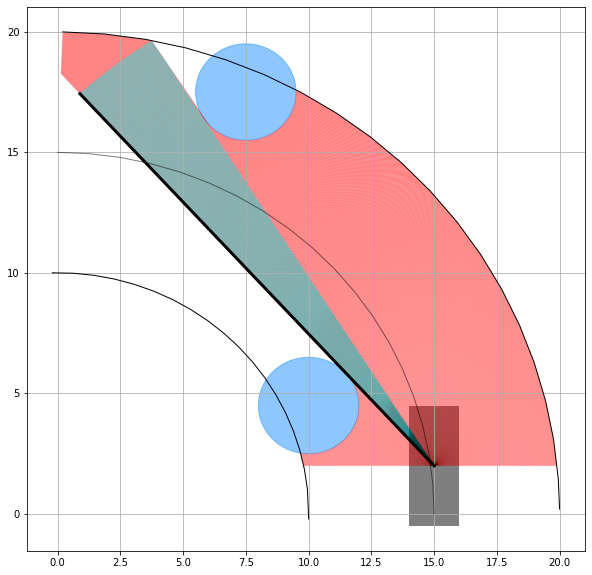

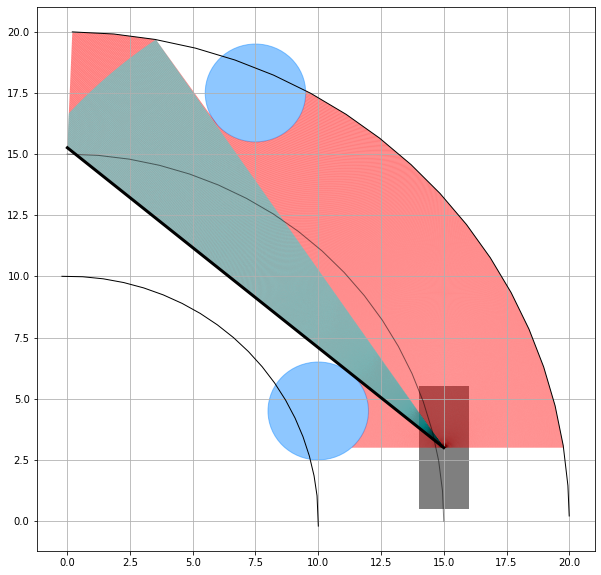

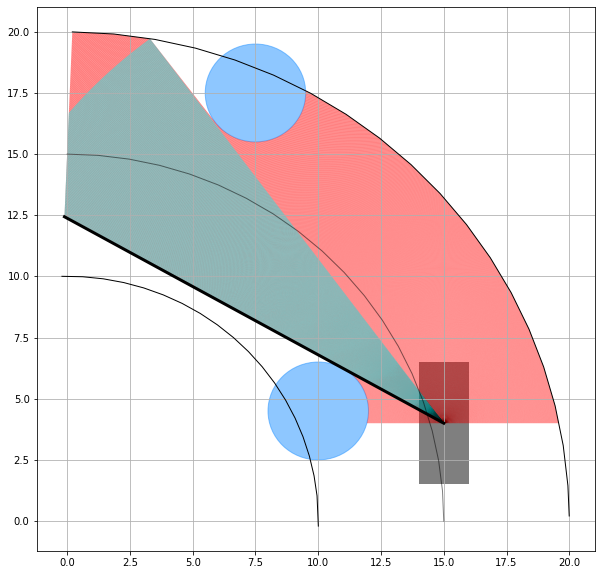

In [7]:
filenames_tuple = FILENAMES[MAIN_DEMO]
pr = path_reader.PathReader(filenames_tuple[0])
obstacles = CircleObstaclesReader().get_obstacles_from_file(filenames_tuple[1])
ref_x, ref_y, ref_x_dir, ref_y_dir = read_ref_path(filenames_tuple[2])

draw_fov_and_gap(
    plt=plt,
    pr=pr,
    ref_x=ref_x,
    ref_y=ref_y,
    ref_x_dir=ref_x_dir,
    ref_y_dir=ref_y_dir,
    obstacles=obstacles,
)

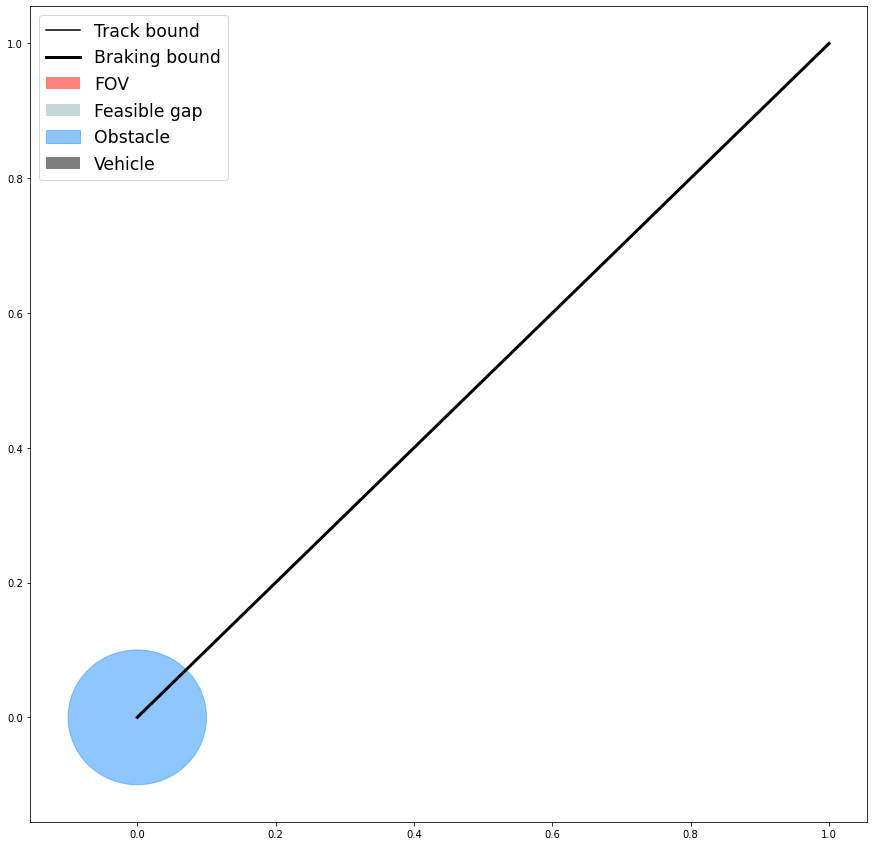

In [8]:
plt.figure(figsize=(15, 15))
labels = Labels()
plt.plot([0, 1], color='#000000', label=labels.track_label)
plt.plot([0, 1], color='#000000', linewidth=3, label=labels.braking_bound)
draw_triangle(plt, gp.Point(0, 0), gp.Point(0, 0), gp.Point(1, 0), color=FOV_COLOR, alpha=ALPHA, label=labels.fov_label)
draw_triangle(plt, gp.Point(0, 0), gp.Point(0, 0), gp.Point(1, 0), color='#8fb3b3', alpha=ALPHA, label=labels.gap_label)
draw_circle(plt, 0, 0, 0.1, color=OBSTACLE_COLOR, alpha=ALPHA, label=labels.obstacle_label)
draw_triangle(plt, gp.Point(0, 0), gp.Point(0, 0), gp.Point(1, 0), color=VEHICLE_COLOR, alpha=ALPHA, label=labels.vehicle_label)

plt.legend(fontsize='xx-large')

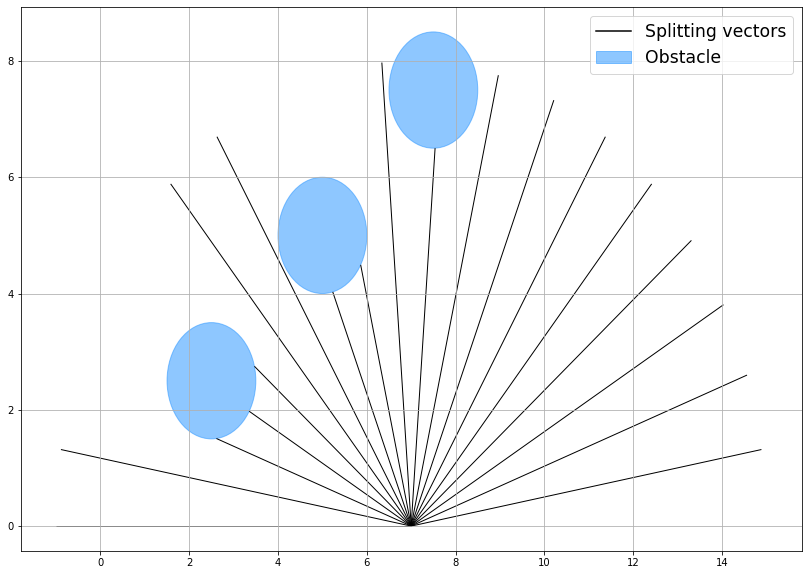

In [9]:
# vector sampler demo
filenames_tuple = FILENAMES[VECTOR_SAMPLER_DEMO]
obstacles = CircleObstaclesReader().get_obstacles_from_file(filenames_tuple[1])
ref_x, ref_y, ref_x_dir, ref_y_dir = read_ref_path(filenames_tuple[2])
draw_fov_and_gap(
    plt,
    figsize=(14, 10),
    pr=None,
    ref_x=ref_x,
    ref_y=ref_y,
    ref_x_dir=ref_x_dir,
    ref_y_dir=ref_y_dir,
    obstacles=obstacles,

    fov_sampler_count=20,
    distance=8,

    obstacle_color=OBSTACLE_COLOR,

    extra_fov_line_color='#000000',
    extra_fov_line_linewidth=1,
    extra_fov_line_alpha=1,

    fov_alpha=0,

    do_draw_track=False,
    do_draw_vehicle=False,
    do_draw_gap=False,
    
    do_show=False,
)

plt.plot([7], color='#000000', label='Splitting vectors')
draw_circle(plt, 0, 0, 0, color=OBSTACLE_COLOR, alpha=ALPHA, label=labels.obstacle_label)
plt.legend(fontsize='xx-large')
plt.grid()
plt.show()


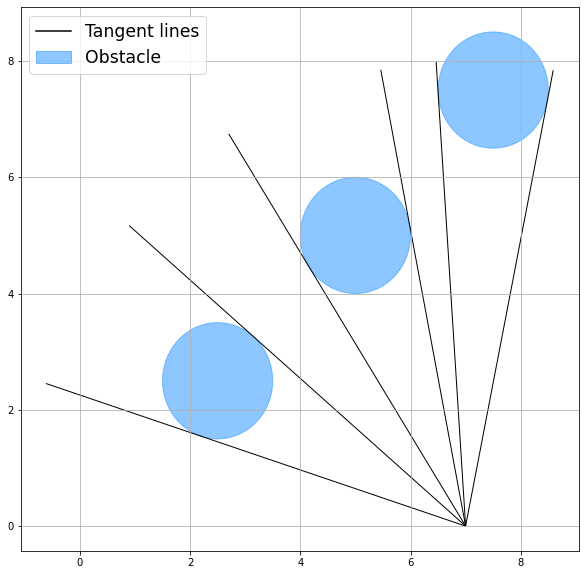

In [10]:
# tangent extractor demo
filenames_tuple = FILENAMES[TANGENT_EXTRACTOR_DEMO]
obstacles = CircleObstaclesReader().get_obstacles_from_file(filenames_tuple[1])
ref_x, ref_y, ref_x_dir, ref_y_dir = read_ref_path(filenames_tuple[2])

distance = 8
tangent_vectors_extractor = fova.FieldOfViewTangentVectorsExtractor(obstacles=obstacles)
for i in range(len(ref_x)):
    plt.figure(figsize=FIGSIZE)
    draw_obstacles(plt, obstacles, color=OBSTACLE_COLOR, alpha=ALPHA)

    view_point = gp.Point(ref_x[i], ref_y[i])
    direction = gp.Vector(ref_x_dir[i], ref_y_dir[i])
    tangent_vectors = tangent_vectors_extractor.extract_tangtent_vectors_list(
        view_point=view_point, distance=distance
    )
    for v, _ in tangent_vectors:
        draw_triangle(
            plt,
            view_point,
            gp.Point(v.x, v.y),
            gp.Point(v.x, v.y),
            color='#000000',
            alpha=1,
            linewidth=1,
        )
    
    plt.plot([7], color='#000000', label='Tangent lines')
    draw_circle(plt, 0, 0, 0, color=OBSTACLE_COLOR, alpha=ALPHA, label=labels.obstacle_label)
    plt.legend(fontsize='xx-large')
    plt.grid()
    plt.show()

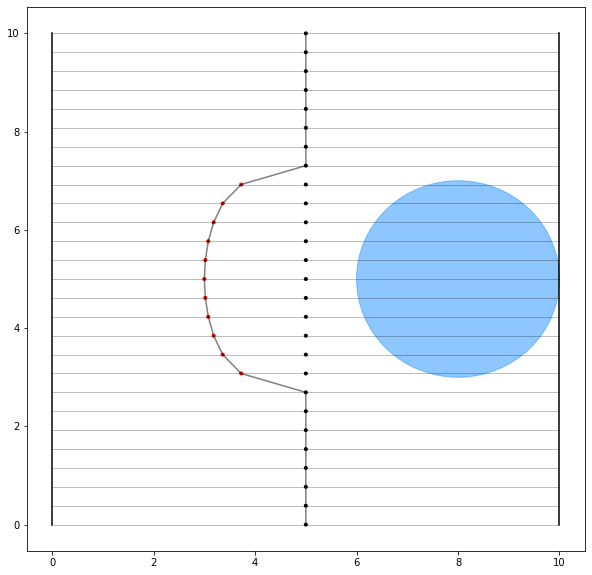

In [11]:
plt.figure(figsize=(10, 10))

LENGTH = 10
WIDTH = 10
N = 25

# boundaries
plt.plot([0, 0], [0, LENGTH], color='#000000')
plt.plot([WIDTH, WIDTH], [0, LENGTH], color='#000000')

# obstacles
obstacles = [(8, 5, 2)]
for obstacle in obstacles:
    draw_circle(plt, *obstacle, color=OBSTACLE_COLOR, alpha=ALPHA)

final_x_coords = []
final_y_coords = []

# central line
for i in range(N + 2):
    y = i * WIDTH / (N + 1)
    x = LENGTH / 2
    final_x_coords.append(x)
    final_y_coords.append(y)
    plt.plot([0, WIDTH], [y, y], color='#000000', alpha=0.5, linewidth=0.5)
    draw_circle(plt, x, y, 0.03, color='#000000', alpha=1)

# shifted line
def _handle_obstacle(indices, obstacle: obstcl.CircleObstacle):
    for i in indices:
        y = i * LENGTH / (N + 1)
        v = gp.Vector(LENGTH, y, gp.Point(0, y))
        w = obstacle.get_intersection_with_vector(v)
        if w is not None:
            final_x_coords[i] = w.x / 2
            draw_circle(plt, w.x / 2, w.y, 0.03, color='#ff0000', alpha=1)

_handle_obstacle(
    range(N + 2),
    obstcl.CircleObstacle(gp.Point(obstacles[0][0], obstacles[0][1]), obstacles[0][2]),
)

plt.plot(final_x_coords, final_y_coords, color='#000000', alpha=0.5)

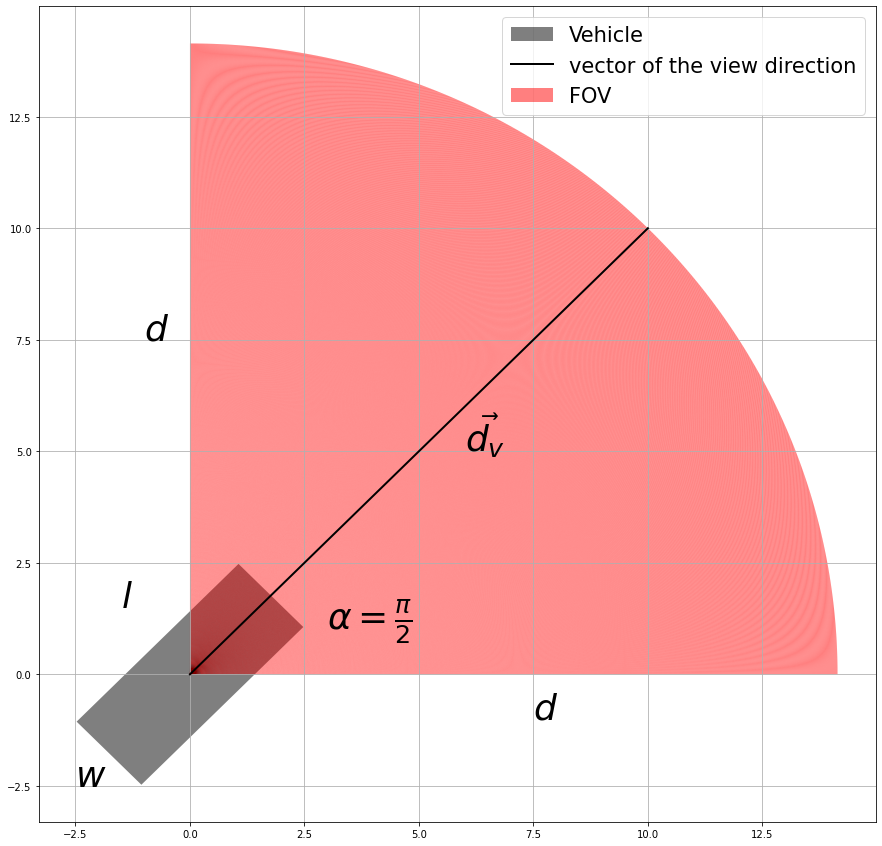

In [53]:
plt.figure(figsize=(15, 15))
labels = Labels()

view_point = gp.Point(0, 0)
direction = gp.Vector(10, 10)
distance = direction.norm()
view_angle = math.pi / 2
length = 5
width = 2

draw_vehicle(
    plt,
    view_point=view_point,
    direction=direction,
    length=length,
    width=width,
    color='#000000',
    alpha=0.5,
    linewidth=0,
    label=labels.vehicle_label,
)

draw_line(
    plt,
    [direction.x, direction.origin.x],
    [direction.y, direction.origin.y],
    label='vector of the view direction',
    linewidth=2,
)

# draw field of view
vectors = fova.FieldOfViewVectorSampler(
    view_point=view_point,
    direction=direction,
    distance=distance,
    view_angle=view_angle,
).sample_view_vectors(count=1000)
for i in range(1, len(vectors)):
    cur_vector = vectors[i]
    prev_vector = vectors[i - 1]
    draw_triangle(
        plt,
        view_point,
        gp.Point(cur_vector.x, cur_vector.y),
        gp.Point(prev_vector.x, prev_vector.y),
        color=FOV_COLOR,
        alpha=ALPHA,
        linewidth=0,
        label=(labels.fov_label if i == 1 else None),
    )

plt.annotate('$l$', xy=(-1.5, 1.5), fontsize=36)
plt.annotate('$w$', xy=(-2.5, -2.5), fontsize=36)
plt.annotate('$d$', xy=(-1, 7.5), fontsize=36)
plt.annotate('$d$', xy=(7.5, -1), fontsize=36)
plt.annotate('$\\vec{d_v}$', xy=(6, 5), fontsize=36)
plt.annotate('$\\alpha=\\frac{\\pi}{2}$', xy=(3, 1), fontsize=36)
plt.grid()
plt.legend(fontsize='xx-large', prop={'size': 21})
plt.show()

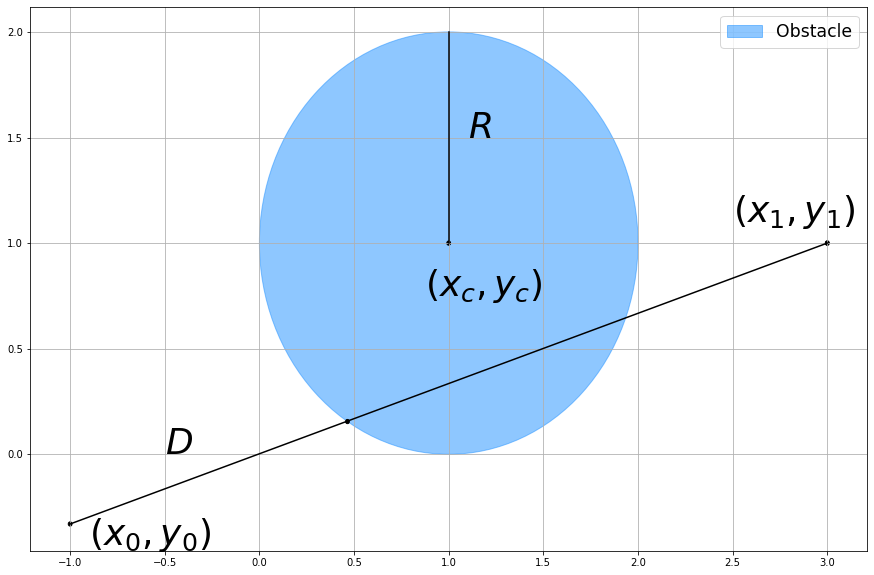

In [77]:
plt.figure(figsize=(15, 10))

draw_circle(plt, 1, 1, radius=1, color=OBSTACLE_COLOR, alpha=ALPHA, label=labels.obstacle_label)
draw_circle(plt, 1, 1, radius=0.01, color='#000000')
draw_circle(plt, -1, -0.33, radius=0.01, color='#000000')
draw_circle(plt, 3, 1, radius=0.01, color='#000000')
draw_circle(plt, 3, 1, radius=0.01, color='#000000')
draw_circle(plt, 0.46515, 0.15505, radius=0.01, color='#000000')
plt.plot([-1, 3], [-0.33, 1], color='#000000')

plt.plot([1, 1], [1, 2], alpha=1, color='#000000')
plt.annotate('$D$', xy=(-0.5, 0), fontsize=36)
plt.annotate('$(x_0, y_0)$', xy=(-0.9, -0.43), fontsize=36)
plt.annotate('$(x_1, y_1)$', xy=(2.5, 1.1), fontsize=36)
plt.annotate('$(x_c, y_c)$', xy=(0.875, 0.75), fontsize=36)
plt.annotate('$R$', xy=(1.1, 1.5), fontsize=36)

plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

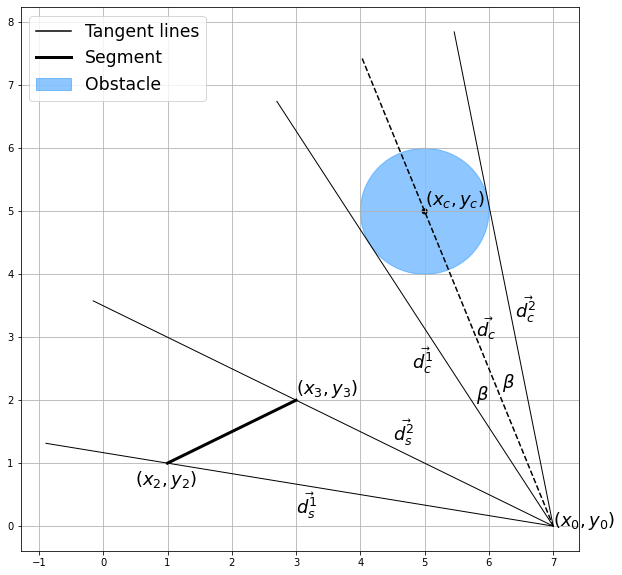

In [123]:
# tangent extractor demo
obstacles = [
    obstcl.CircleObstacle(gp.Point(5, 5), 1),
    obstcl.SegmentObstacle(gp.Point(1, 1), gp.Point(3, 2))
]

x, y, x_dir, y_dir = 7,0,0,1
distance = 8

tangent_vectors_extractor = fova.FieldOfViewTangentVectorsExtractor(obstacles=obstacles)
plt.figure(figsize=FIGSIZE)
draw_obstacles(plt, obstacles, color=OBSTACLE_COLOR, alpha=ALPHA, linewidth=3)

view_point = gp.Point(ref_x[i], ref_y[i])
direction = gp.Vector(ref_x_dir[i], ref_y_dir[i])
tangent_vectors = tangent_vectors_extractor.extract_tangtent_vectors_list(
    view_point=view_point, distance=distance
)
for v, _ in tangent_vectors:
    draw_line(
        plt,
        [x, v.x],
        [y, v.y],
        color='#000000',
        alpha=1,
        linewidth=1,
    )

mid_v = tangent_vectors[0][0].rotate_by(
    tangent_vectors[0][0].get_angle_between(tangent_vectors[1][0]) / 2
)

plt.plot([7], color='#000000', label='Tangent lines')
plt.plot([7], color='#000000', label='Segment', linewidth=3)
plt.plot([mid_v.x, mid_v.origin.x], [mid_v.y, mid_v.origin.y], '--k')
draw_circle(plt, 0, 0, 0, color=OBSTACLE_COLOR, alpha=ALPHA, label=labels.obstacle_label)

plt.annotate('$(x_c, y_c)$', xy=(5, 5.1), fontsize=18)
plt.annotate('$(x_0, y_0)$', xy=(7, 0), fontsize=18)
plt.annotate('$\\beta$', xy=(5.8, 2), fontsize=18)
plt.annotate('$\\beta$', xy=(6.2, 2.2), fontsize=18)
plt.annotate('$(x_2, y_2)$', xy=(0.5, 0.65), fontsize=18)
plt.annotate('$(x_3, y_3)$', xy=(3, 2.1), fontsize=18)

plt.annotate('$\\vec{d_s^1}$', xy=(3, 0.2), fontsize=18)
plt.annotate('$\\vec{d_s^2}$', xy=(4.5, 1.35), fontsize=18)

plt.annotate('$\\vec{d_c^1}$', xy=(4.8, 2.5), fontsize=18)
plt.annotate('$\\vec{d_c^2}$', xy=(6.4, 3.3), fontsize=18)
plt.annotate('$\\vec{d_c}$', xy=(5.8, 3), fontsize=18)
draw_circle(plt, 5, 5, 0.04, color='#000000')
# draw_circle(plt, 4.15664, 4.46265, 0.04, color='#000000')
plt.legend(fontsize='xx-large', loc="upper left")
plt.grid()
plt.show()